# REDES NUERONALES RECURRENTES

Implementacion con un set de señales trigonometricas.

## Funciones comunes a todas la partes

In [1]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [2]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  # si tengo profundida de mi serie temporal, me quedo solamente con la 1ra.
  series = series[:,:,0]
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [4]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X


In [5]:
# funciones de entrenamiento

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")

        bar = tqdm(dataloader['eval'])
        model.eval()

        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")

def predict(model, dataloader, reduced=0):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X[:,reduced:,:]
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [6]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad:
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()
  print('-'*84)
  print('NRO TOTAL DE PARAMETROS:')
  t_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(t_params)
  print('-'*84)

## Generación de serie de datos y visualización

In [7]:
n_steps = 50
n_future = 1
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 1) (7000, 1, 1)
X and y Valid shape
(2000, 50, 1) (2000, 1, 1)
X and y Test shape
(1000, 50, 1) (1000, 1, 1)


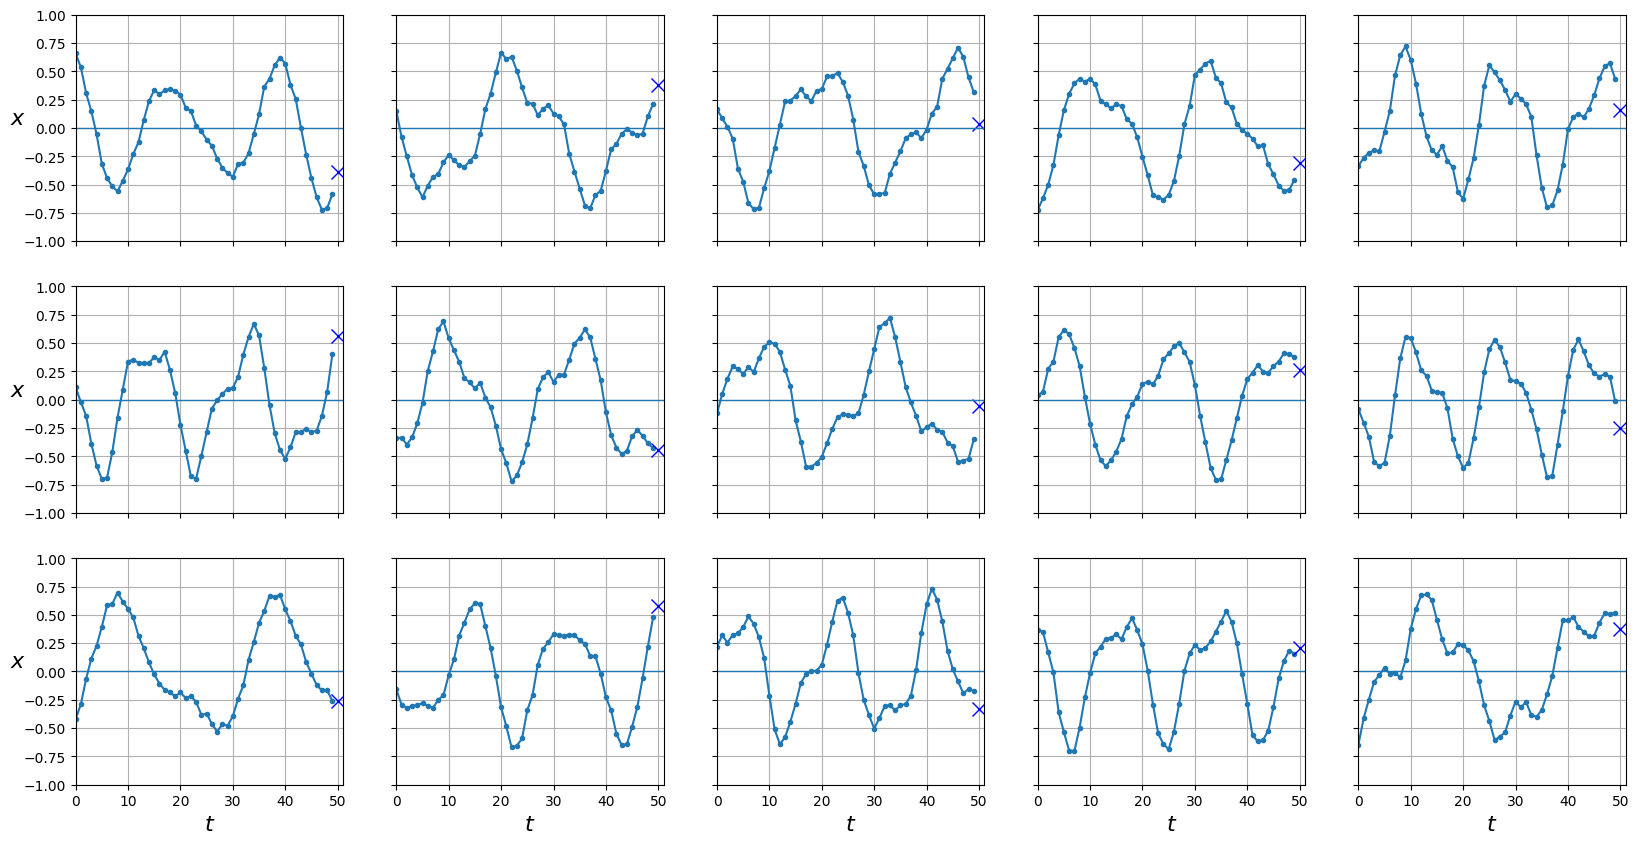

In [ ]:
plot_series(X_test, y_test)

In [8]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

## MLP para comparar luego con RNN

In [9]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
mlp

MLP(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [10]:
fit(mlp, dataloader)

epoch numero:  0


valid_loss 0.04518: 100%|██████████| 32/32 [00:00<00:00, 198.95it/s]


epoch numero:  1


valid_loss 0.02458: 100%|██████████| 32/32 [00:00<00:00, 203.79it/s]


epoch numero:  2


valid_loss 0.01760: 100%|██████████| 32/32 [00:00<00:00, 197.84it/s]


epoch numero:  3


valid_loss 0.01364: 100%|██████████| 32/32 [00:00<00:00, 198.97it/s]


epoch numero:  4


valid_loss 0.01113: 100%|██████████| 32/32 [00:00<00:00, 232.57it/s]


epoch numero:  5


valid_loss 0.00961: 100%|██████████| 32/32 [00:00<00:00, 178.94it/s]


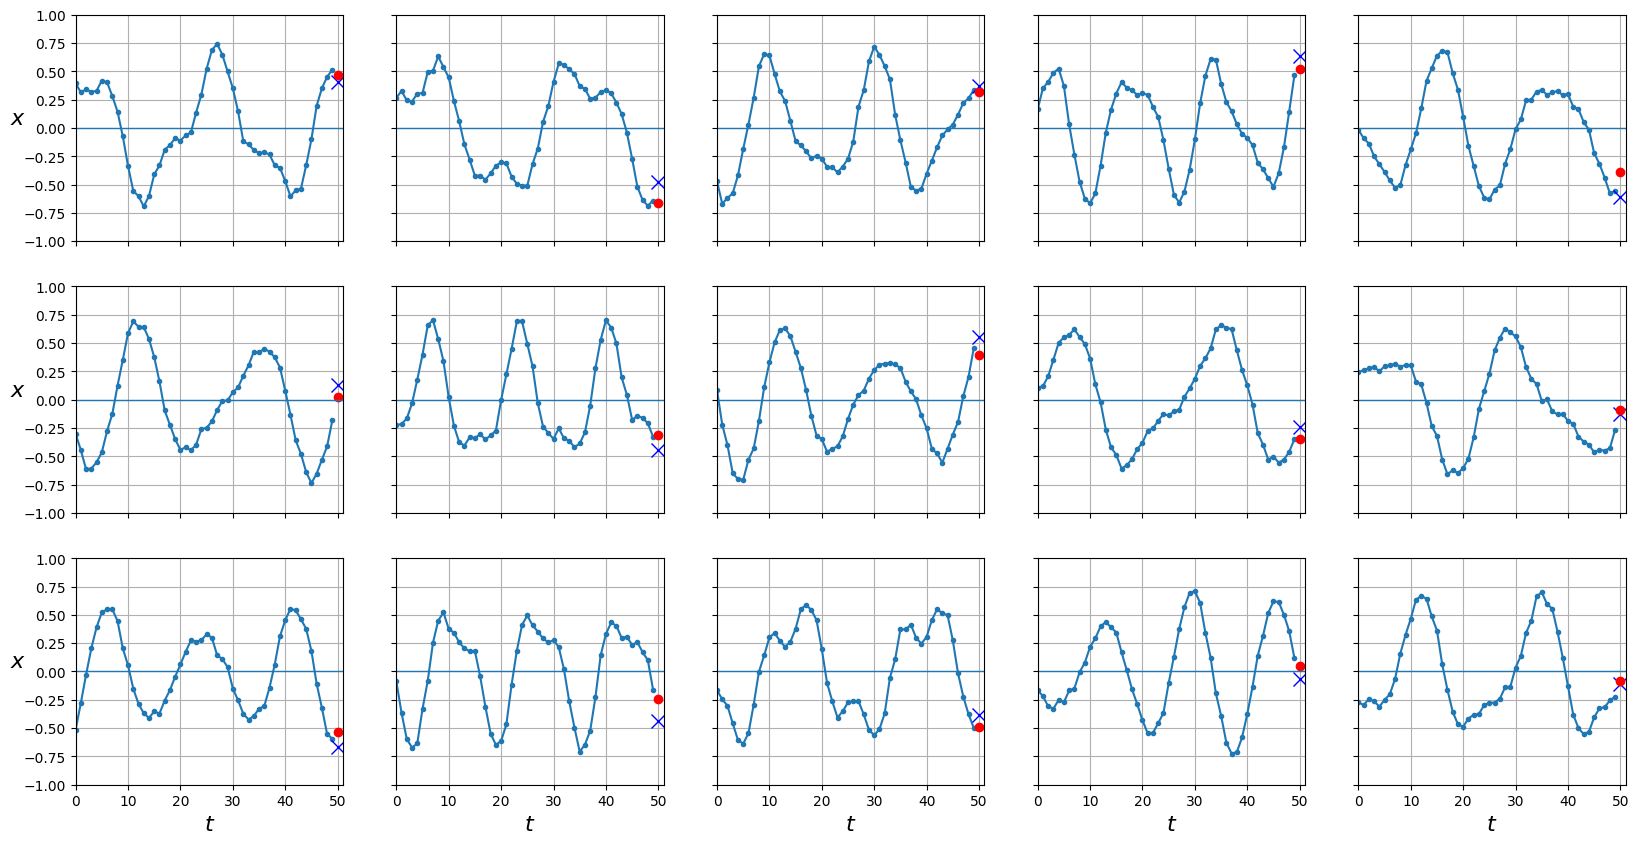

Error cuadratico medio de la estimación final: 


0.00936432

In [11]:
y_pred = predict(mlp, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred)

## Clase RNN para probar distintas configuraciones.

In [13]:
class RNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=1, num_layers=1, n_out=1):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = torch.nn.Linear(in_features=hidden_size, out_features=n_out)
    # la fc la colocamos para cuando empleemos mas de 1 neurona hidden, ya que
    # tenemos que combinar todas las hidden de la salida de RNN en 1 solo
    # valor a predecir en el futuro. Para eso usaremos las FC.
    # ver en el forward cómo se leen los valores

  def forward(self, x):
    x, h = self.rnn(x)
    # ATENCION!!
    # La salida tentrá una dimensión del [batch x largo de señal x numero de hidden]
    # y a mi FC solo quiero pasarle la última predicción temporal, de todas sus hidden.
    # por eso, me quedo con:
    #       -- todo el batch
    #       -- solo la última predición temporal
    #       -- de todas sus hidden
    x = self.fc(x[:,-1:,:])

    y = torch.squeeze(x, 1)
    return y



##RNN simple de 1 sola hidden


In [14]:
rnn = RNN(input_size=1, hidden_size=1, num_layers=1)
rnn

RNN(
  (rnn): RNN(1, 1, batch_first=True)
  (fc): Linear(in_features=1, out_features=1, bias=True)
)

In [15]:
# veamos que arroja nuestra rnn

entrada = torch.rand(50)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.4216, 0.0965, 0.7164, 0.1673, 0.3078, 0.1357, 0.6232, 0.7068, 0.7427,
        0.9280, 0.3923, 0.2268, 0.5049, 0.5306, 0.8607, 0.3158, 0.6052, 0.2281,
        0.1518, 0.6552, 0.0339, 0.4395, 0.7771, 0.9126, 0.5547, 0.0270, 0.3805,
        0.1925, 0.3943, 0.3761, 0.2507, 0.8817, 0.0660, 0.8621, 0.9731, 0.9596,
        0.3234, 0.6047, 0.1961, 0.2541, 0.7850, 0.0758, 0.6915, 0.3393, 0.9804,
        0.6172, 0.0148, 0.6788, 0.8965, 0.0287])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [16]:
# paso la entrada a la red
salida = rnn(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[-0.8815]], grad_fn=<SqueezeBackward1>)
salida shape:
torch.Size([1, 1])


In [17]:
fit(rnn, dataloader)

epoch numero:  0


valid_loss 0.94765: 100%|██████████| 32/32 [00:00<00:00, 182.29it/s]


epoch numero:  1


valid_loss 0.29747: 100%|██████████| 32/32 [00:00<00:00, 195.73it/s]


epoch numero:  2


valid_loss 0.22558: 100%|██████████| 32/32 [00:00<00:00, 186.72it/s]


epoch numero:  3


valid_loss 0.19656: 100%|██████████| 32/32 [00:00<00:00, 198.48it/s]


epoch numero:  4


valid_loss 0.18629: 100%|██████████| 32/32 [00:00<00:00, 147.71it/s]


epoch numero:  5


valid_loss 0.17868: 100%|██████████| 32/32 [00:00<00:00, 185.81it/s]


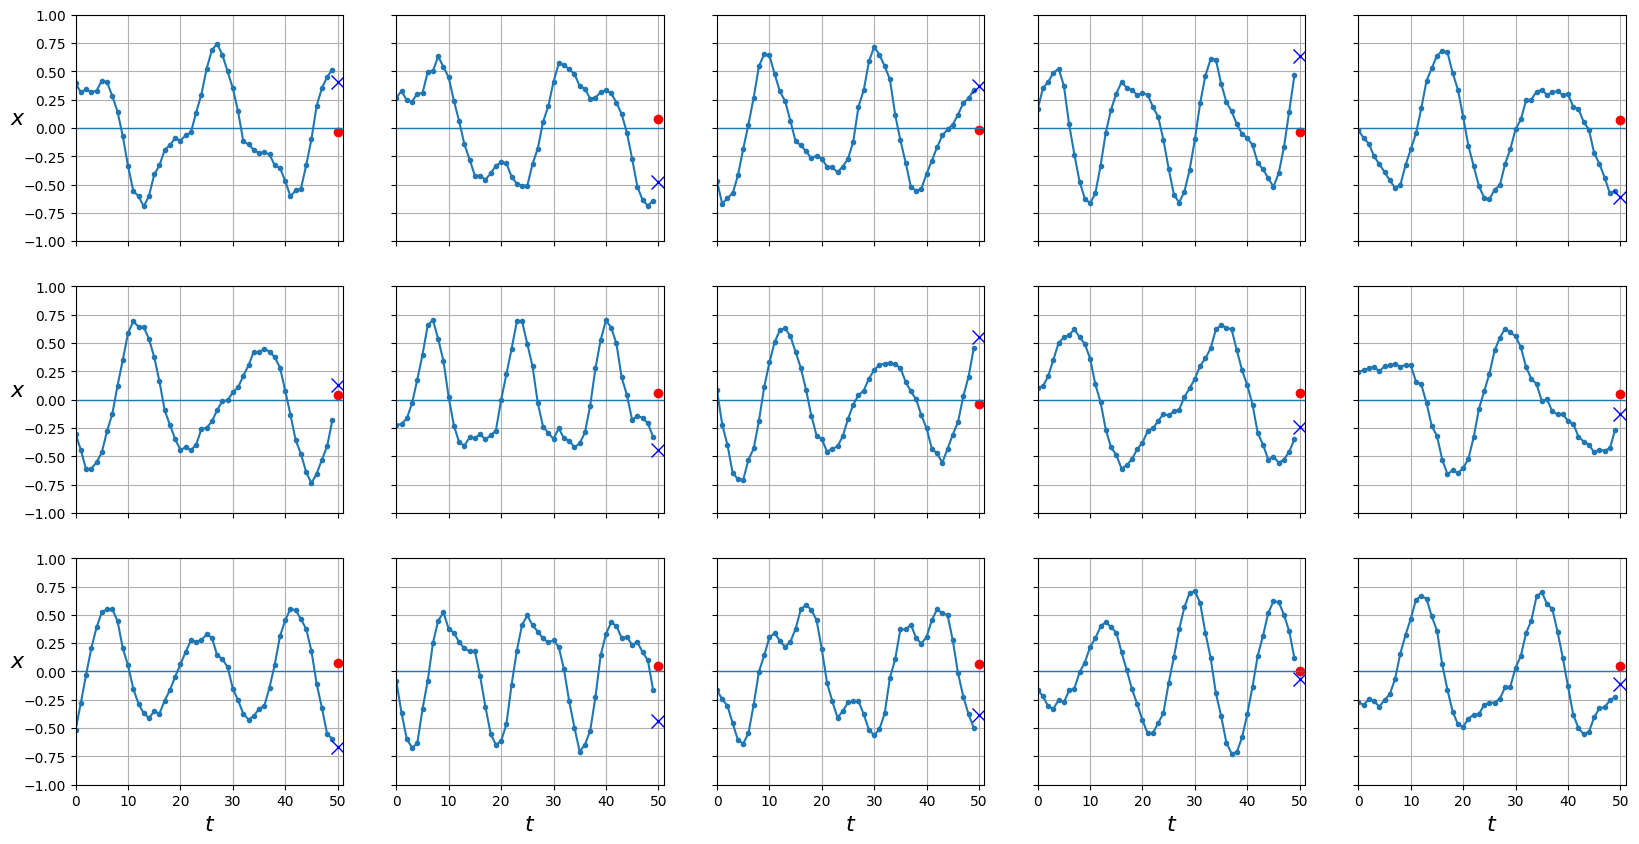

Error cuadratico medio de la estimación final: 


0.18066467

In [18]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

### Comparacion de parámetros entre MLP y RNN implementada

In [19]:
# parámetros en el MLP

imp_param(mlp)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 50])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
51
------------------------------------------------------------------------------------


In [20]:
# parámetros en el RNN

imp_param(rnn)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
6
------------------------------------------------------------------------------------


##RNN con mas neuronas hidden

In [21]:
rnn_2 = RNN(input_size=1, hidden_size=5, num_layers=1)
rnn_2

RNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
# parámetros en el RNN

imp_param(rnn_2)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([5, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([5, 5])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 5])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
46
------------------------------------------------------------------------------------


In [23]:
# veamos que arroja nuestra rnn_2

entrada = torch.rand(20)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.4202, 0.5591, 0.2901, 0.6804, 0.4139, 0.7891, 0.7327, 0.7172, 0.7934,
        0.2215, 0.3698, 0.9142, 0.6189, 0.8862, 0.7982, 0.6384, 0.8940, 0.1522,
        0.9395, 0.2501])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 20, 1])

In [ ]:
# paso la entrada a la red
salida = rnn_2(entrada)

print('salida de la red (largo igual al input):')
print(salida)
print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[0.1557]], grad_fn=<SqueezeBackward1>)
salida shape:
torch.Size([1, 1])


In [24]:
fit(rnn_2, dataloader)

epoch numero:  0


valid_loss 0.11252: 100%|██████████| 32/32 [00:00<00:00, 144.60it/s]


epoch numero:  1


valid_loss 0.06460: 100%|██████████| 32/32 [00:00<00:00, 165.46it/s]


epoch numero:  2


valid_loss 0.04148: 100%|██████████| 32/32 [00:00<00:00, 140.18it/s]


epoch numero:  3


valid_loss 0.02878: 100%|██████████| 32/32 [00:00<00:00, 151.70it/s]


epoch numero:  4


valid_loss 0.02107: 100%|██████████| 32/32 [00:00<00:00, 176.73it/s]


epoch numero:  5


valid_loss 0.01552: 100%|██████████| 32/32 [00:00<00:00, 179.66it/s]


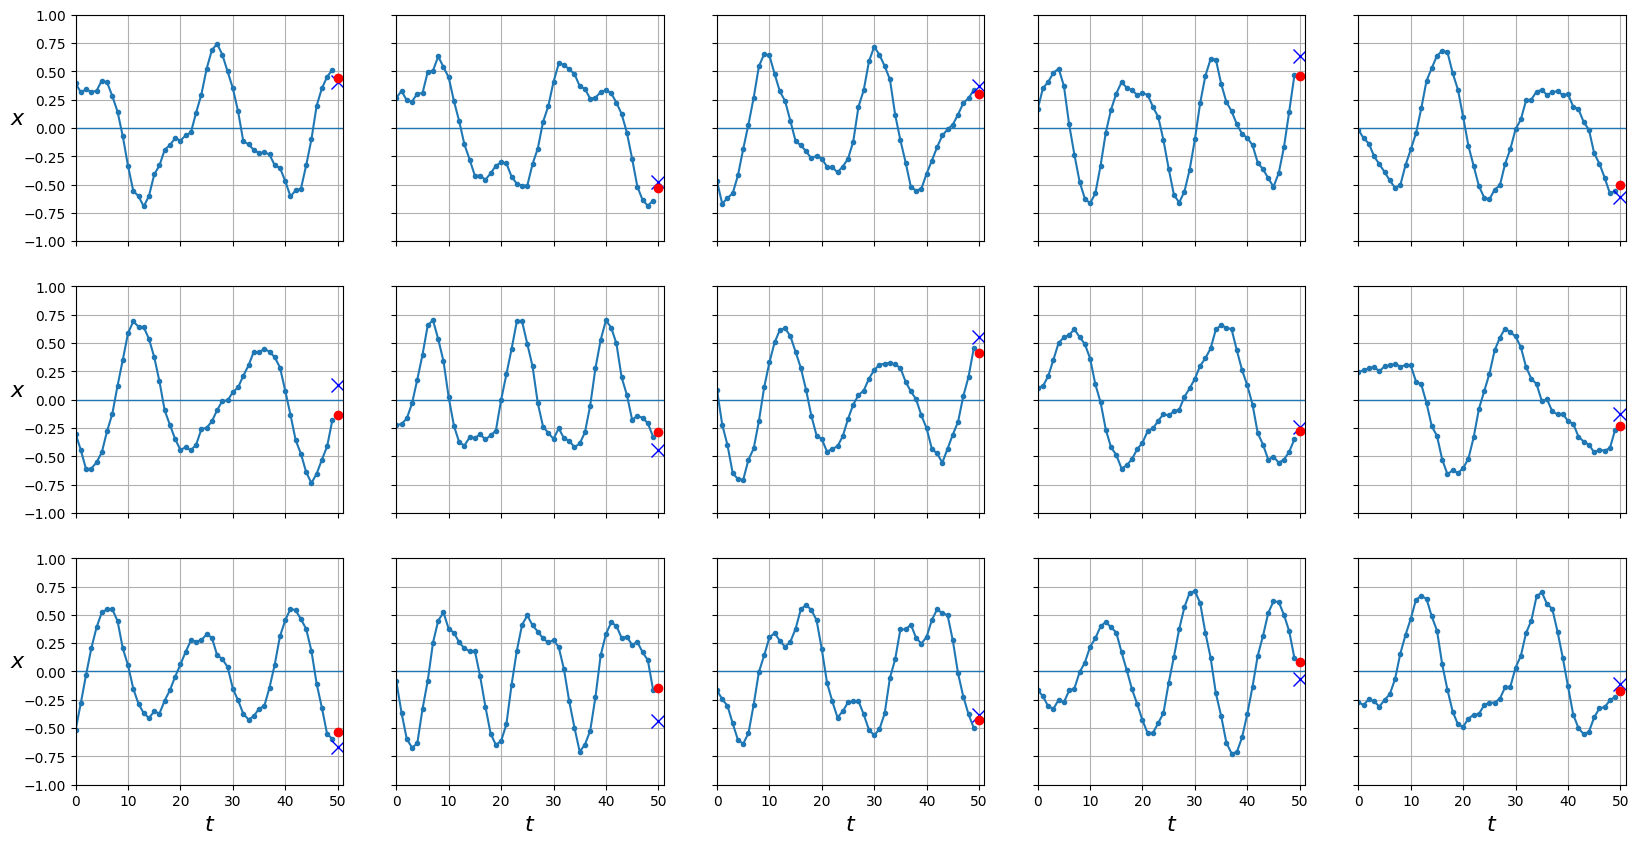

Error cuadratico medio de la estimación final: 


0.01579583

In [25]:
# la probmos con el test
y_pred = predict(rnn_2, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


y_testb = np.squeeze(y_test)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

## RNN con mas layers





In [26]:
rnn_deep = RNN(input_size=1, hidden_size=5, num_layers=2)
fit(rnn_deep, dataloader)

epoch numero:  0


valid_loss 0.11793: 100%|██████████| 32/32 [00:00<00:00, 149.33it/s]


epoch numero:  1


valid_loss 0.03500: 100%|██████████| 32/32 [00:00<00:00, 107.11it/s]


epoch numero:  2


valid_loss 0.01066: 100%|██████████| 32/32 [00:00<00:00, 144.35it/s]


epoch numero:  3


valid_loss 0.00897: 100%|██████████| 32/32 [00:00<00:00, 148.15it/s]


epoch numero:  4


valid_loss 0.00805: 100%|██████████| 32/32 [00:00<00:00, 142.86it/s]


epoch numero:  5


valid_loss 0.00735: 100%|██████████| 32/32 [00:00<00:00, 149.33it/s]


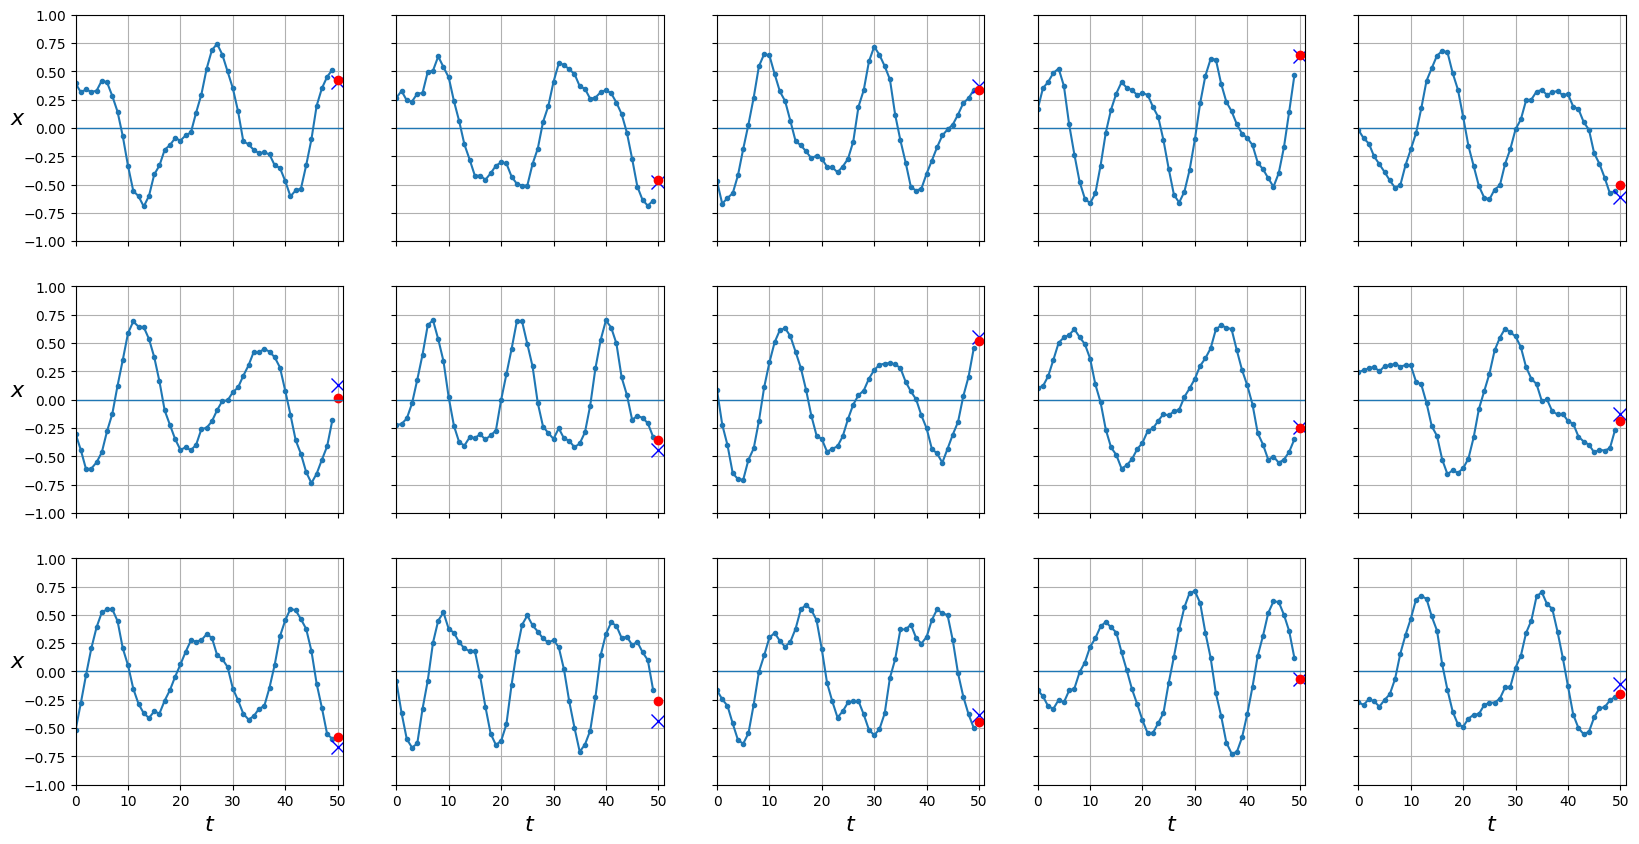

Error cuadratico medio de la estimación final: 


0.0068189697

In [27]:
y_pred = predict(rnn_deep, dataloader['test'], reduced = 9)
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

In [28]:
# parámetros en el RNN

imp_param(rnn_deep)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([5, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([5, 5])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([5, 5])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([5, 5])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 5])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

-----------------

## Predicciones a futuro

series shape
(10000, 60, 1)
X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


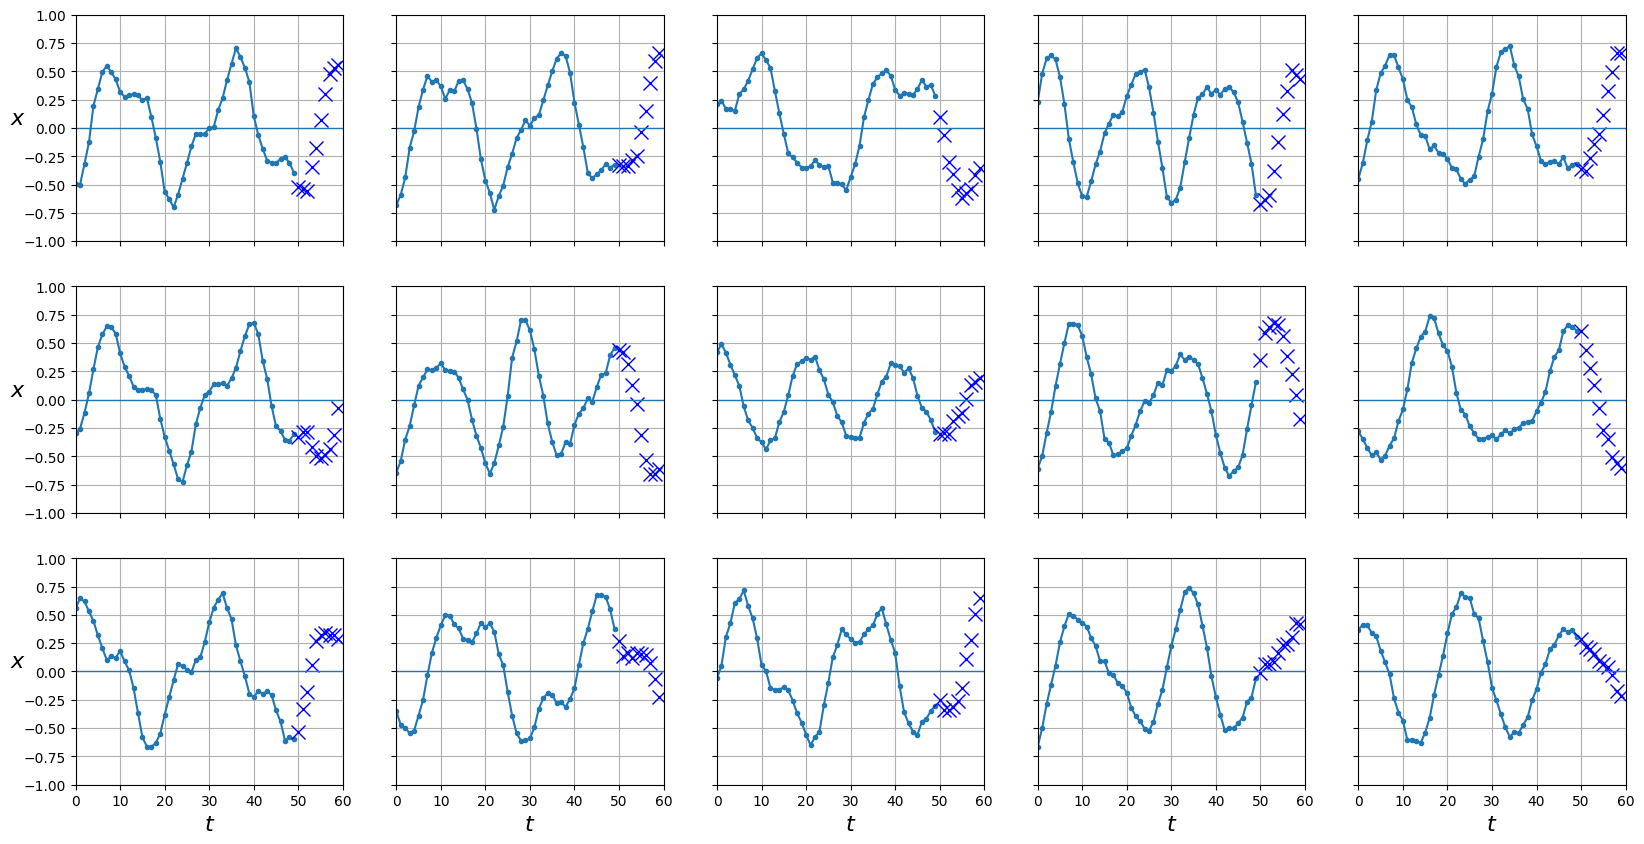

(1000, 10, 1)
(1000, 1)


In [29]:
# generamos unos nuevos datos para tener con qué comparar

n_steps = 50
n_future = 10

series = generate_time_series(10000, n_steps, n_future)
print('series shape')
print(series.shape)

X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

# ploteamos
plot_series(X_test, y_test)
print(y_test.shape)
print(y_test[:,0,:].shape)

In [30]:
# tenemos q armar un nuevo dataloader que pase 1 solo valor a futuro
# pero tengamos los siguientes 9 para ver el error de nuestra propia iteración
dataset = {
    'train': TimeSeriesDataset(X_train, y_train[:,0,:]),
    'eval': TimeSeriesDataset(X_valid, y_valid[:,0,:]),
    'test': TimeSeriesDataset(X_test, y_test[:,0,:], train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}
print(type(dataloader))


<class 'dict'>


### predecimos 10 valores a futuro, colocando la última predicción en la entrada, hasta llegar a 10 pasos iterativos

In [31]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como output:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como output:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1])


In [32]:
# entreno de nueva la ultima red y graficamos

fit(rnn_deep, dataloader)


epoch numero:  0


valid_loss 0.00404: 100%|██████████| 32/32 [00:00<00:00, 151.63it/s]


epoch numero:  1


valid_loss 0.00373: 100%|██████████| 32/32 [00:00<00:00, 137.92it/s]


epoch numero:  2


valid_loss 0.00370: 100%|██████████| 32/32 [00:00<00:00, 143.78it/s]


epoch numero:  3


valid_loss 0.00369: 100%|██████████| 32/32 [00:00<00:00, 110.40it/s]


epoch numero:  4


valid_loss 0.00365: 100%|██████████| 32/32 [00:00<00:00, 150.45it/s]


epoch numero:  5


valid_loss 0.00365: 100%|██████████| 32/32 [00:00<00:00, 115.06it/s]


In [ ]:
print(xs.shape)

sal = rnn_deep(xs)
sal.shape

torch.Size([64, 50, 1])


torch.Size([64, 1])

(1000, 10)


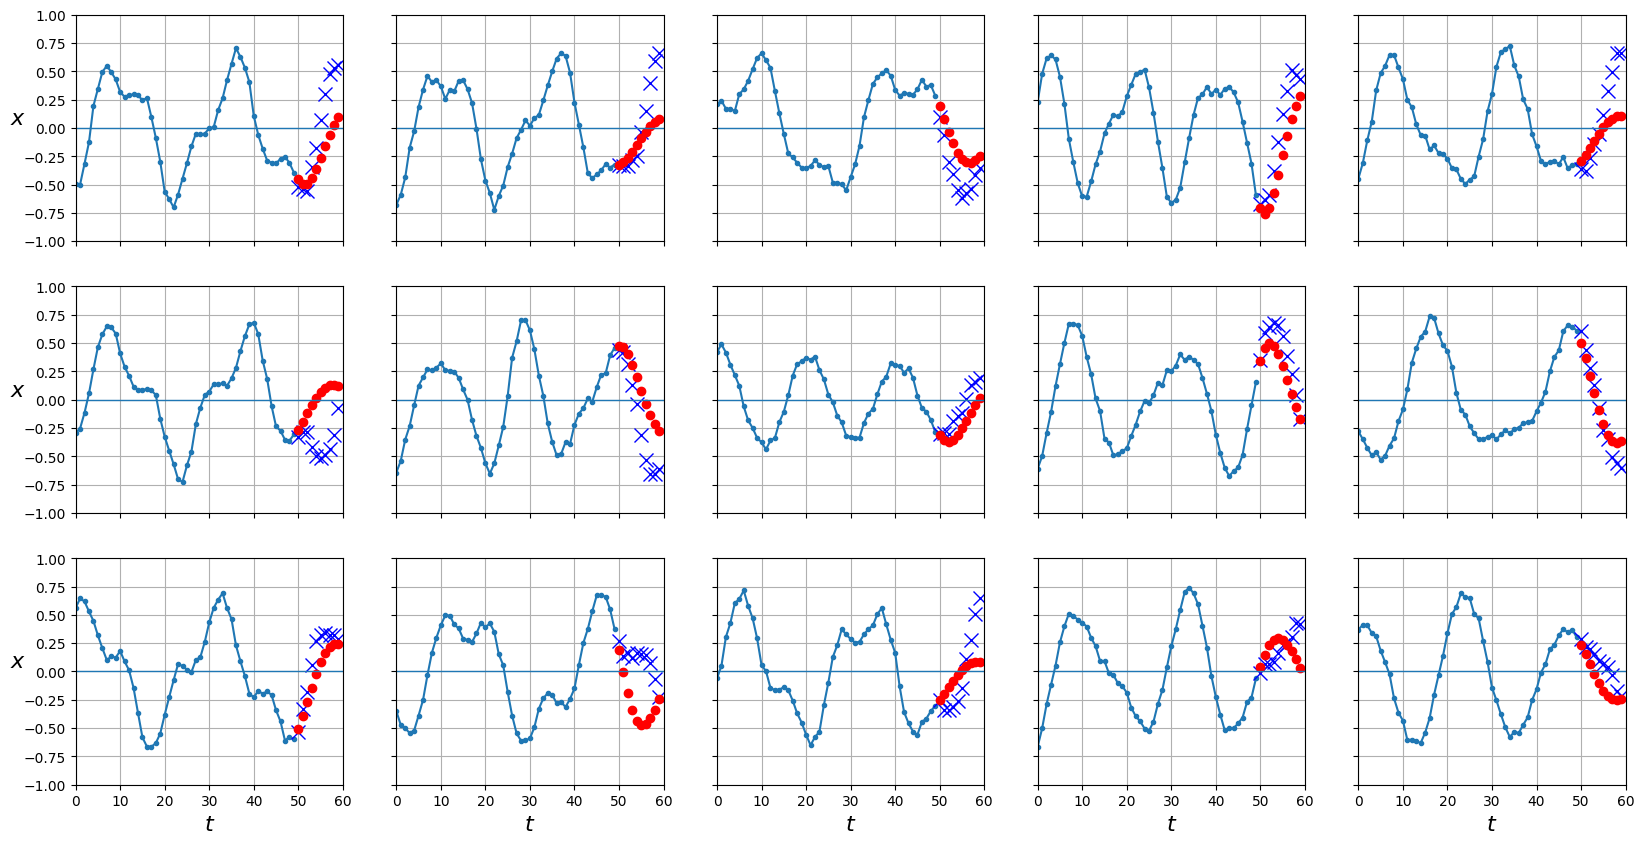

(1000, 10, 1)
(1000, 10)


0.06613307

In [33]:
# graficamos

X = X_test
for step_ahead in range(10):
    #print(step_ahead)
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0) # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    #print(inputs.shape)
    y_pred_one = predict(rnn_deep, inputs).cpu().numpy()
    #print(y_pred_one.shape)
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)
    #print(X.shape)

y_pred = X[:, n_steps:, -1]
print(y_pred.shape)
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)

epoch numero:  0


valid_loss 0.00690: 100%|██████████| 32/32 [00:00<00:00, 242.26it/s]


epoch numero:  1


valid_loss 0.00486: 100%|██████████| 32/32 [00:00<00:00, 286.86it/s]


epoch numero:  2


valid_loss 0.00396: 100%|██████████| 32/32 [00:00<00:00, 292.54it/s]


epoch numero:  3


valid_loss 0.00344: 100%|██████████| 32/32 [00:00<00:00, 274.52it/s]


epoch numero:  4


valid_loss 0.00317: 100%|██████████| 32/32 [00:00<00:00, 214.00it/s]


epoch numero:  5


valid_loss 0.00301: 100%|██████████| 32/32 [00:00<00:00, 136.51it/s]


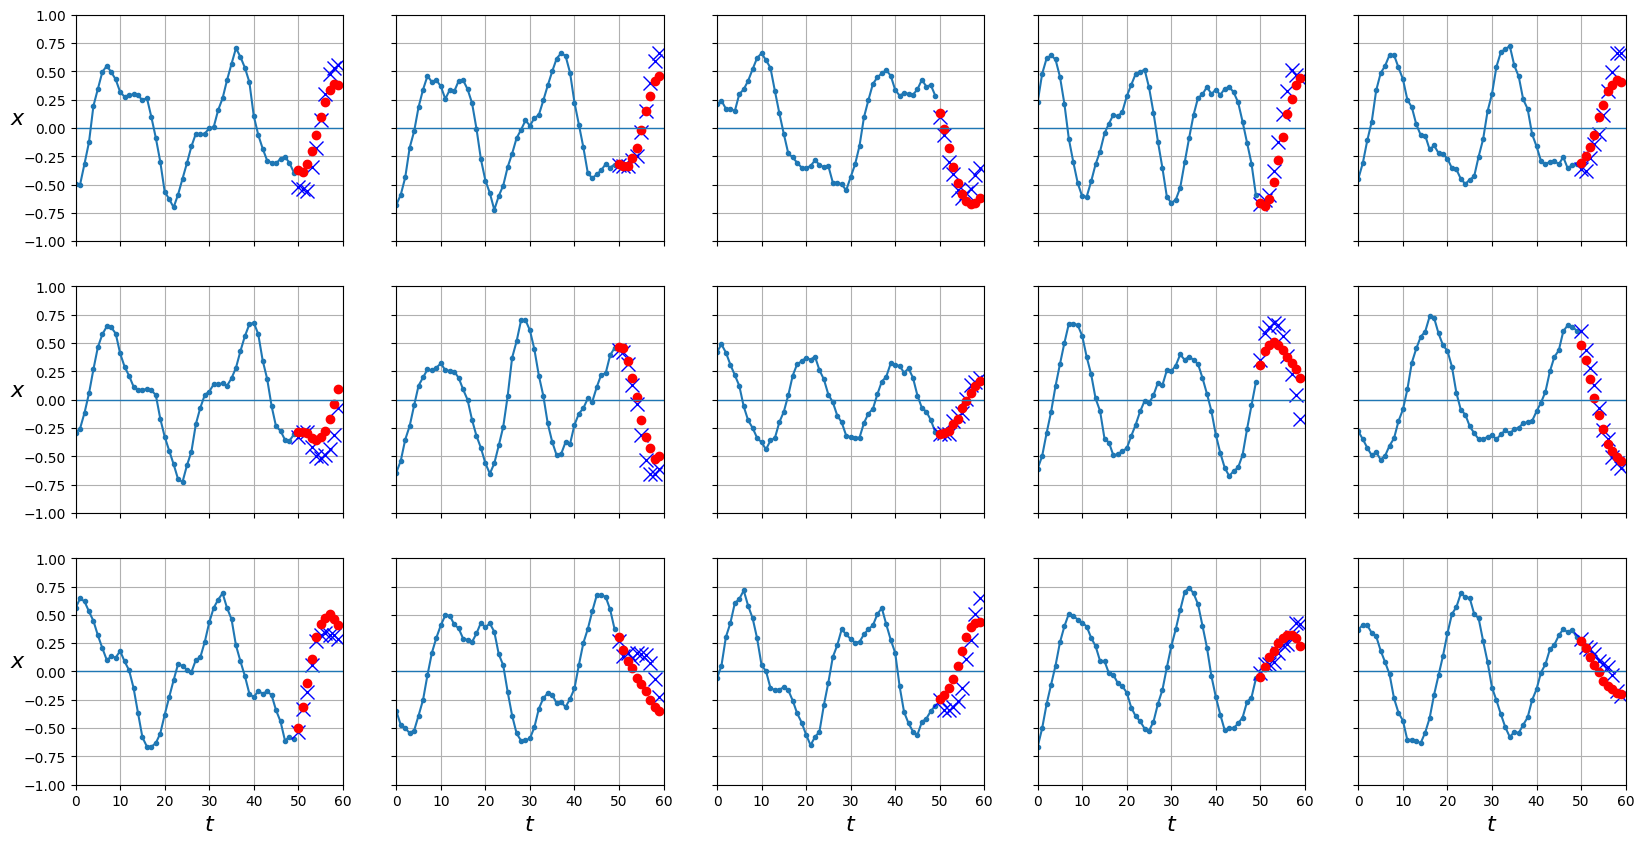

(1000, 10, 1)
(1000, 10)


0.01864716

In [34]:
# lo comparamos en el mlp
# entreno de nuevo el mlp con los nuevos datos y graficamos

fit(mlp, dataloader)

X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)  # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    y_pred_one = predict(mlp, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)


### Podemos configurar a la red prediga 10 valores finales..., colocano n_out = 10

In [35]:
# armamos unos nuevos datos, ya que ahora mi Y objetivo tiene longitud 10

n_steps = 50
n_future = 10
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


In [36]:
#
# tenemos q armar un nuevo dataloader que pase 10 valores a futuro

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader_10 = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}


In [37]:
# creamos un nuevo objeto, ahora con n_out de la FC igual a 10
# (queremos ver 10 valores a futuro)

rnn_10 = RNN(input_size=1, hidden_size=3, num_layers=2, n_out=10)
fit(rnn_10, dataloader_10)

epoch numero:  0


valid_loss 0.19692: 100%|██████████| 32/32 [00:00<00:00, 154.49it/s]


epoch numero:  1


valid_loss 0.15047: 100%|██████████| 32/32 [00:00<00:00, 133.70it/s]


epoch numero:  2


valid_loss 0.14231: 100%|██████████| 32/32 [00:00<00:00, 155.52it/s]


epoch numero:  3


valid_loss 0.13876: 100%|██████████| 32/32 [00:00<00:00, 119.66it/s]


epoch numero:  4


valid_loss 0.13140: 100%|██████████| 32/32 [00:00<00:00, 153.17it/s]


epoch numero:  5


valid_loss 0.11894: 100%|██████████| 32/32 [00:00<00:00, 127.53it/s]


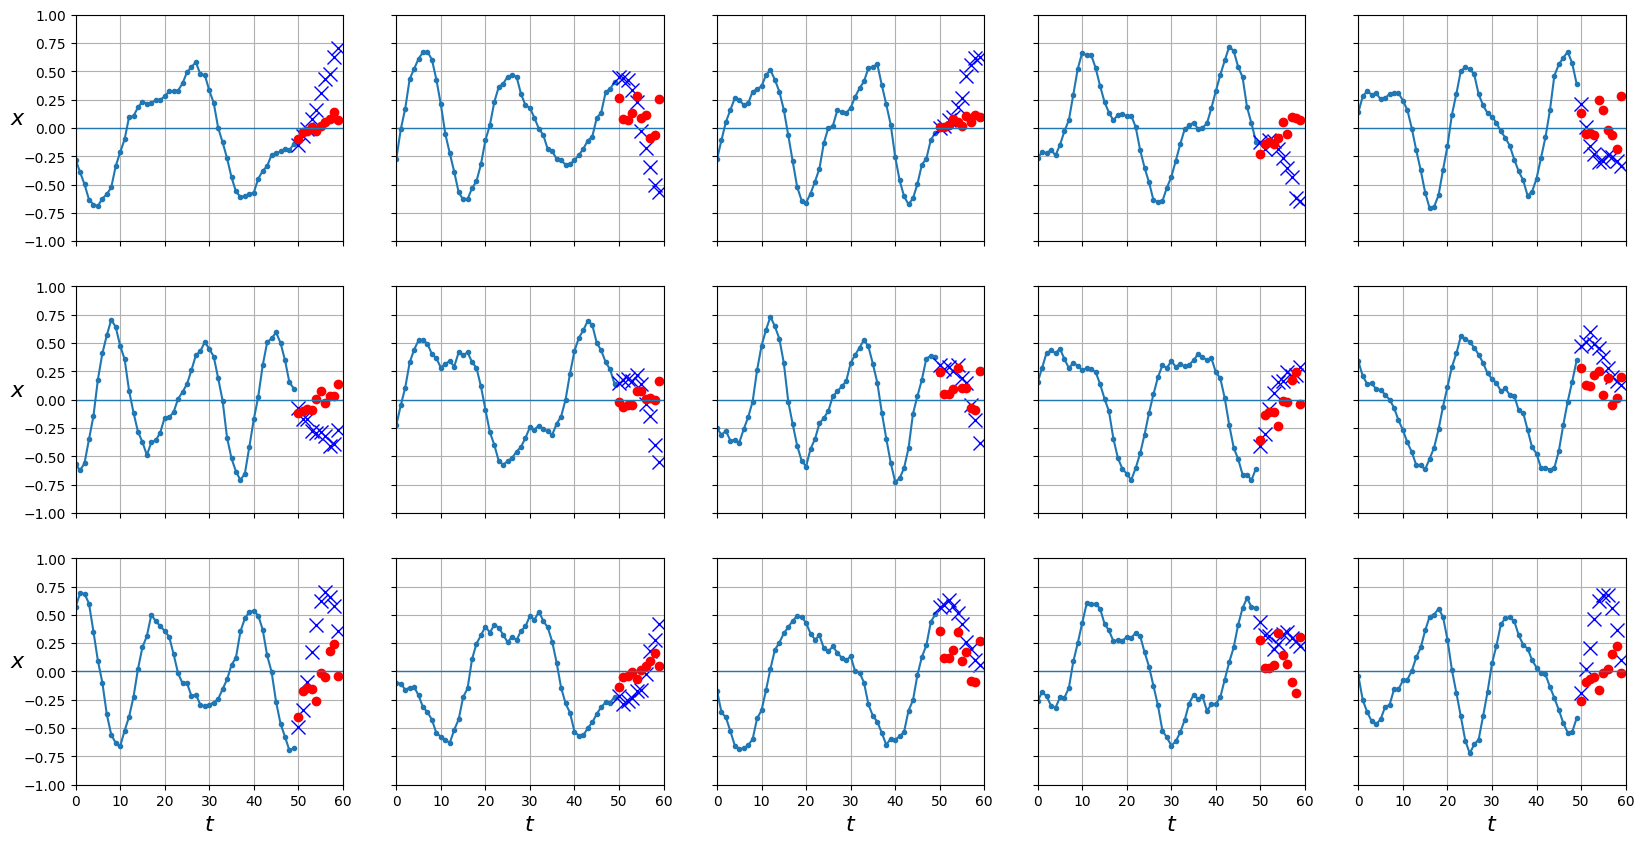

0.11704147

In [45]:
y_pred = predict(rnn_10, dataloader_10['test'], reduced=40)
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

# PROBAR MODIFICAR EL ARGUMENTO REDUCED!!

### MLP que predice 10 muestras a futuro

In [39]:
# lo comparamos en el mlp pero que prediga 10 valores a futuro
# lo redefino para tener N out = 10
mlp_10 = MLP(n_steps, n_future)

# entreno de nuevo el mlp con los nuevos datos y graficamos

fit(mlp_10, dataloader_10)



epoch numero:  0


valid_loss 0.05954: 100%|██████████| 32/32 [00:00<00:00, 232.00it/s]


epoch numero:  1


valid_loss 0.04504: 100%|██████████| 32/32 [00:00<00:00, 246.77it/s]


epoch numero:  2


valid_loss 0.03815: 100%|██████████| 32/32 [00:00<00:00, 228.34it/s]


epoch numero:  3


valid_loss 0.03397: 100%|██████████| 32/32 [00:00<00:00, 285.67it/s]


epoch numero:  4


valid_loss 0.03119: 100%|██████████| 32/32 [00:00<00:00, 273.76it/s]


epoch numero:  5


valid_loss 0.02905: 100%|██████████| 32/32 [00:00<00:00, 263.55it/s]


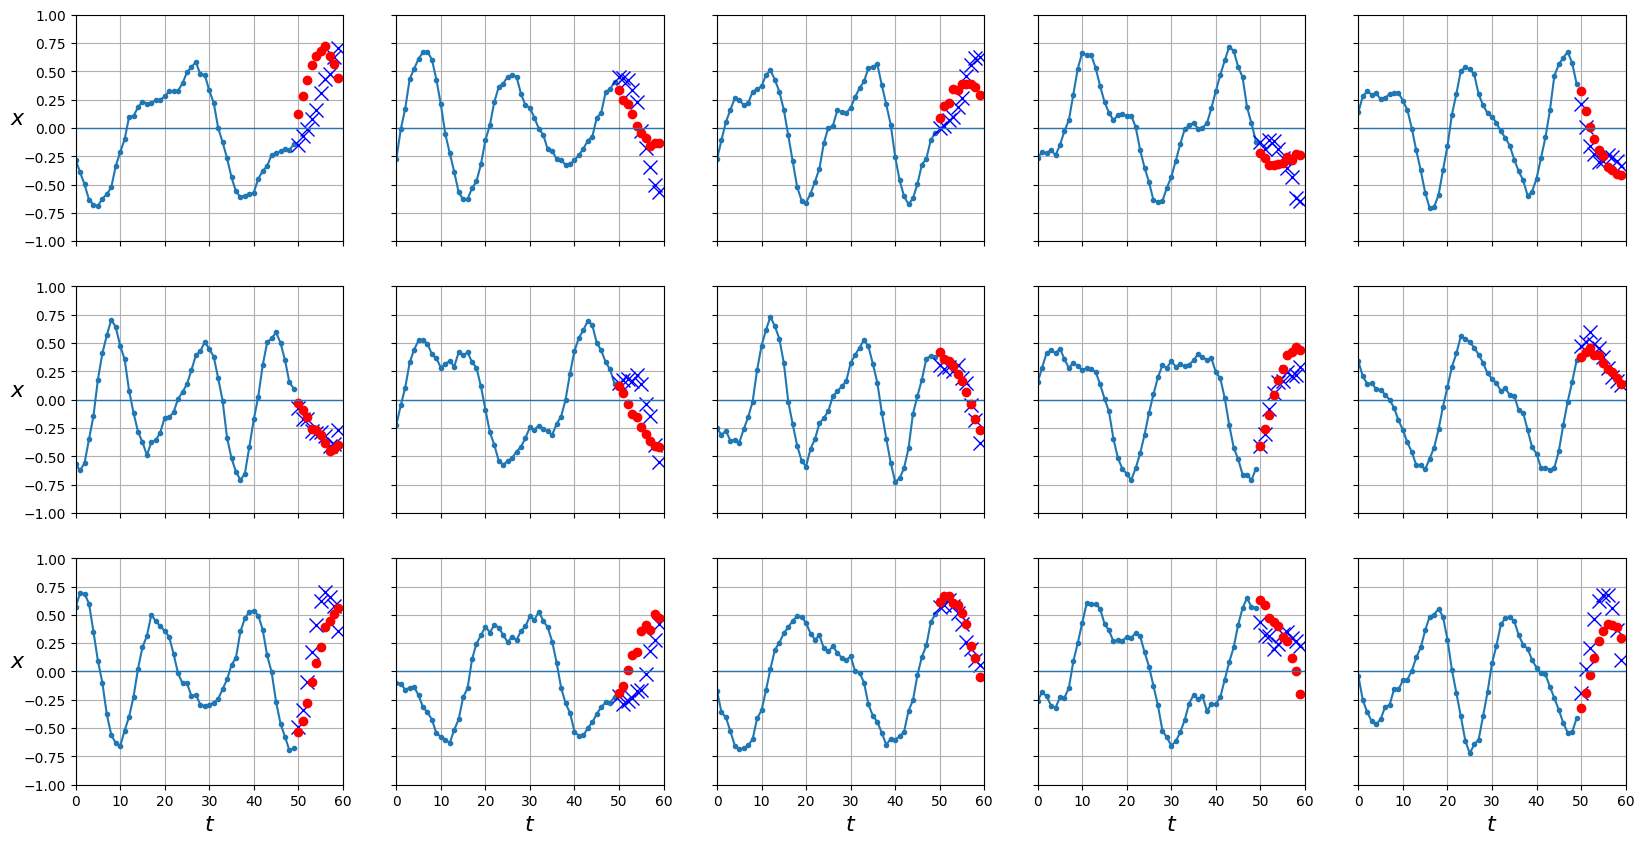

(1000, 10, 1)
torch.Size([1000, 10])


0.028568167

In [44]:
# ploteo y veo el error total
y_pred = predict(mlp_10, dataloader_10['test'], reduced=0)
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)

### EJERCICIO!

Mejorar nuestra arq de RRN2 para que prediga con mejor presición que el MLP.

Recordar probar modificar el argumento 'reduced' al momento de hacer el predict

## Por si se quiere graficar 1 sola gráfica

In [ ]:
# función que plotea una sola serie (inputs y outputs)
def plot_series2(x, y, y_pred, x_label="$t$", y_label="$x$"):
  x = np.squeeze(x)
  y = np.squeeze(y)
  y_pred = np.squeeze(y_pred)
  plt.plot( x, ".-")
  plt.plot(range(len(x), len(x)+len(y)),y,'bx', markersize=10)
  plt.plot(range(len(x), len(x)+len(y)),y_pred,'ro', markersize=10)

  plt.grid(True)

  plt.axis([0, len(x)+len(y), -1, 1])

  plt.show()

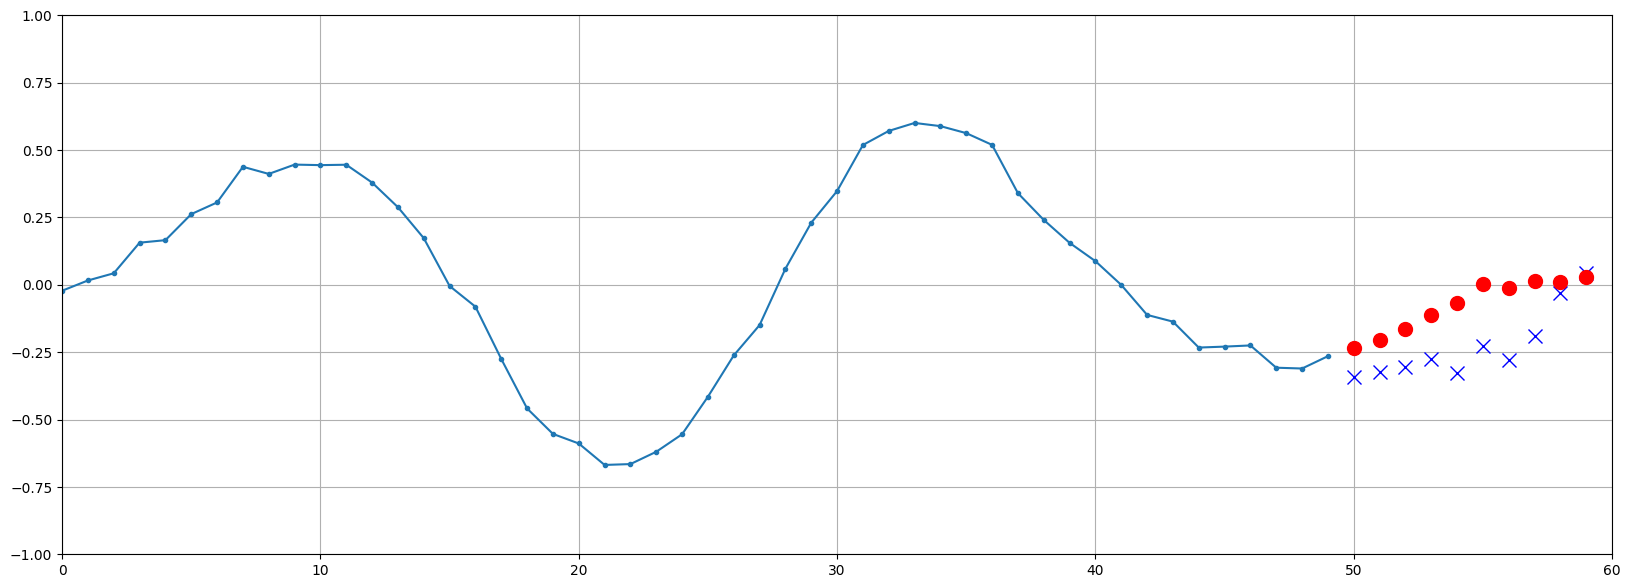

In [ ]:
n = 5
plt.figure(figsize=[20,7])
plot_series2(X_test[n,:,0], y_test[n,:,0], y_pred[n,:].cpu().numpy())


## input size

Se incorpora la derivada como un feature adicional (le damos más profundidad a la input)

In [46]:
# Funcion para generar base de datos de señales con el feature de derivada
def generate_time_series_derivada(batch_size, n_steps, n_future, derivada=False):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    if derivada:
      fc_ser = series[:,0]
      serie_dev = np.diff(series, axis=1, prepend=fc_ser[:,None])
      series = np.stack([series, serie_dev], axis=-1)
    else:
      series = series[..., np.newaxis]
    return series.astype(np.float32)


In [47]:
# probamos el feature si funciona
serie_derivada = generate_time_series_derivada(100, 50, 1, derivada=True)
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
serie_derivada.shape

batch x largo x nro features(si paso mas de 1 feature por tiempo)


(100, 51, 2)

In [48]:
# para los y deseados, solamente queremos hacer regresión sobre la señal
# (no su derivada). Entonces en y solo sacamos la 1ra muestra de la dimensión
# profundidad

n_steps = 50
n_future = 1
series = generate_time_series_derivada(10000, n_steps, n_future, derivada=True)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:, 0]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 2) (7000, 1)
X and y Valid shape
(2000, 50, 2) (2000, 1)
X and y Test shape
(1000, 50, 2) (1000, 1)


In [49]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader_dev = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

### RRN con input_size = 2 para tomar la derivada del input como input

In [50]:
rnn_dev = RNN(input_size=2, hidden_size=5, num_layers=1)
rnn_dev

RNN(
  (rnn): RNN(2, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [51]:
imp_param(rnn_dev)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([5, 2])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([5, 5])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 5])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
51
------------------------------------------------------------------------------------


In [52]:
# veamos que arroja nuestra rnn

entrada = torch.rand(20,2)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([[0.6926, 0.5332],
        [0.3689, 0.6882],
        [0.6497, 0.5159],
        [0.4924, 0.1109],
        [0.6951, 0.6328],
        [0.8551, 0.9783],
        [0.8572, 0.0170],
        [0.8165, 0.3344],
        [0.5275, 0.2144],
        [0.1556, 0.2714],
        [0.1627, 0.2176],
        [0.1471, 0.5722],
        [0.1790, 0.1894],
        [0.1626, 0.0713],
        [0.4789, 0.9753],
        [0.6192, 0.9702],
        [0.8909, 0.0331],
        [0.2905, 0.5897],
        [0.0967, 0.5767],
        [0.1328, 0.1615]])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 20, 2])

In [53]:
# paso la entrada a la red
salida = rnn_dev(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[0.1176]], grad_fn=<SqueezeBackward1>)
salida shape:
torch.Size([1, 1])


In [54]:
fit(rnn_dev, dataloader_dev)

epoch numero:  0


valid_loss 0.11531: 100%|██████████| 32/32 [00:00<00:00, 176.70it/s]


epoch numero:  1


valid_loss 0.03412: 100%|██████████| 32/32 [00:00<00:00, 132.99it/s]


epoch numero:  2


valid_loss 0.00932: 100%|██████████| 32/32 [00:00<00:00, 144.81it/s]


epoch numero:  3


valid_loss 0.00732: 100%|██████████| 32/32 [00:00<00:00, 106.46it/s]


epoch numero:  4


valid_loss 0.00652: 100%|██████████| 32/32 [00:00<00:00, 176.95it/s]


epoch numero:  5


valid_loss 0.00604: 100%|██████████| 32/32 [00:00<00:00, 179.86it/s]


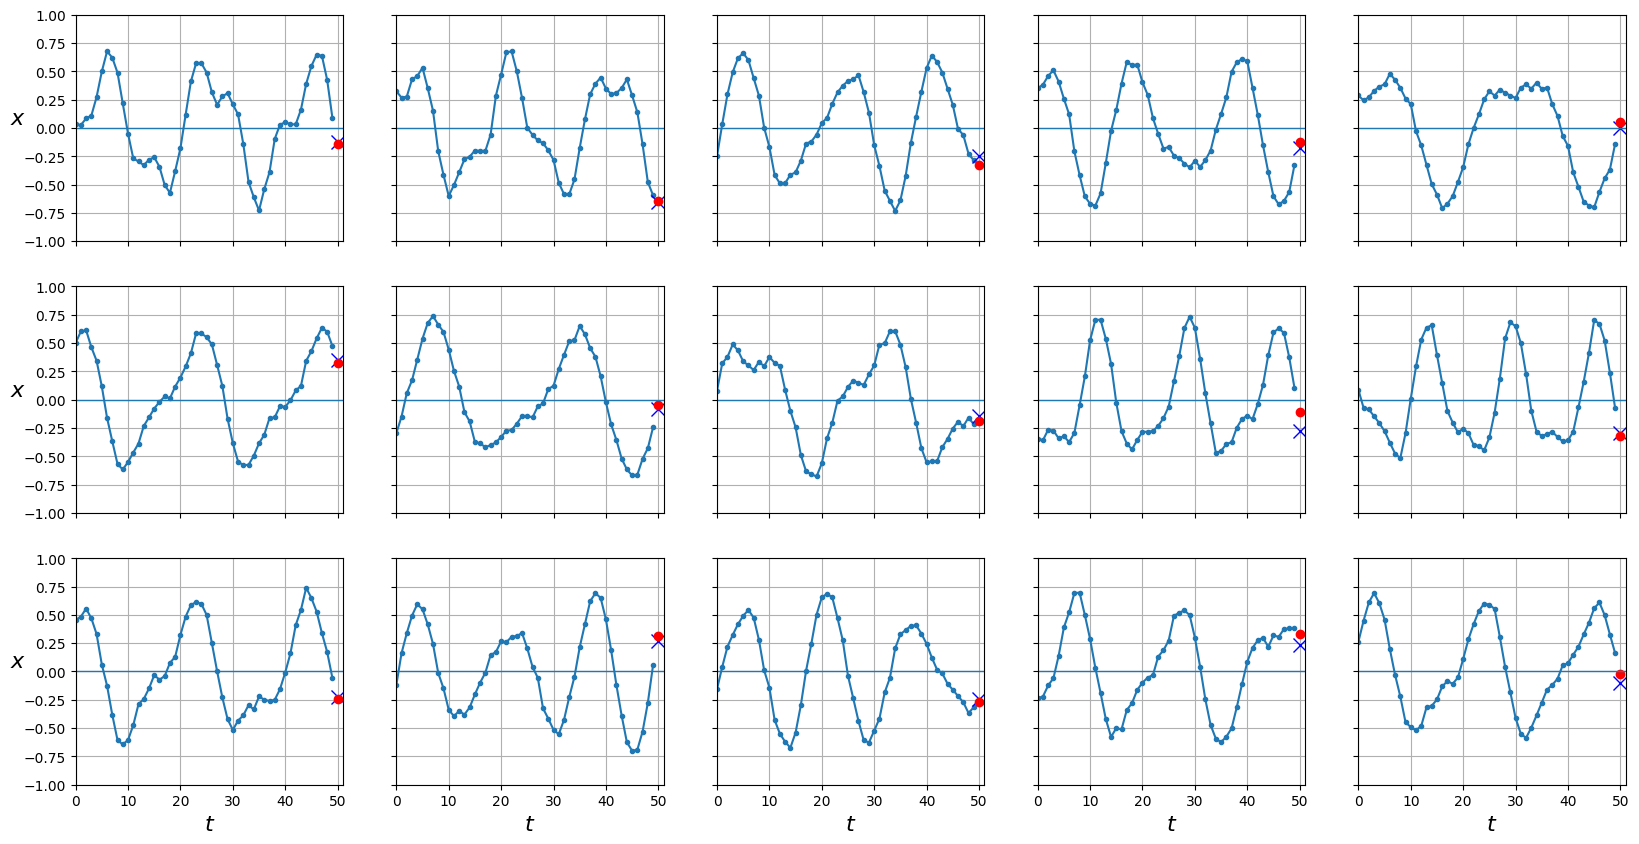

y_test shape:
(1000, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.006123594

In [55]:
y_pred = predict(rnn_dev, dataloader_dev['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

### comparamos la misma arq de red, pero sin el feature "derivada"

Para esto tenemos que armar una nueva arq con input_size = 1 y conservar el resto de hiperparámetros.

In [56]:
rnn_sin_dev = RNN(input_size=1, hidden_size=5, num_layers=1)
rnn_sin_dev

RNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [57]:
imp_param(rnn_sin_dev)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([5, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([5, 5])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 5])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
46
------------------------------------------------------------------------------------


In [58]:
fit(rnn_sin_dev, dataloader)

epoch numero:  0


valid_loss 0.16164: 100%|██████████| 32/32 [00:00<00:00, 144.25it/s]


epoch numero:  1


valid_loss 0.10621: 100%|██████████| 32/32 [00:00<00:00, 191.58it/s]


epoch numero:  2


valid_loss 0.05733: 100%|██████████| 32/32 [00:00<00:00, 157.06it/s]


epoch numero:  3


valid_loss 0.03052: 100%|██████████| 32/32 [00:00<00:00, 158.18it/s]


epoch numero:  4


valid_loss 0.01592: 100%|██████████| 32/32 [00:00<00:00, 145.77it/s]


epoch numero:  5


valid_loss 0.01020: 100%|██████████| 32/32 [00:00<00:00, 172.02it/s]


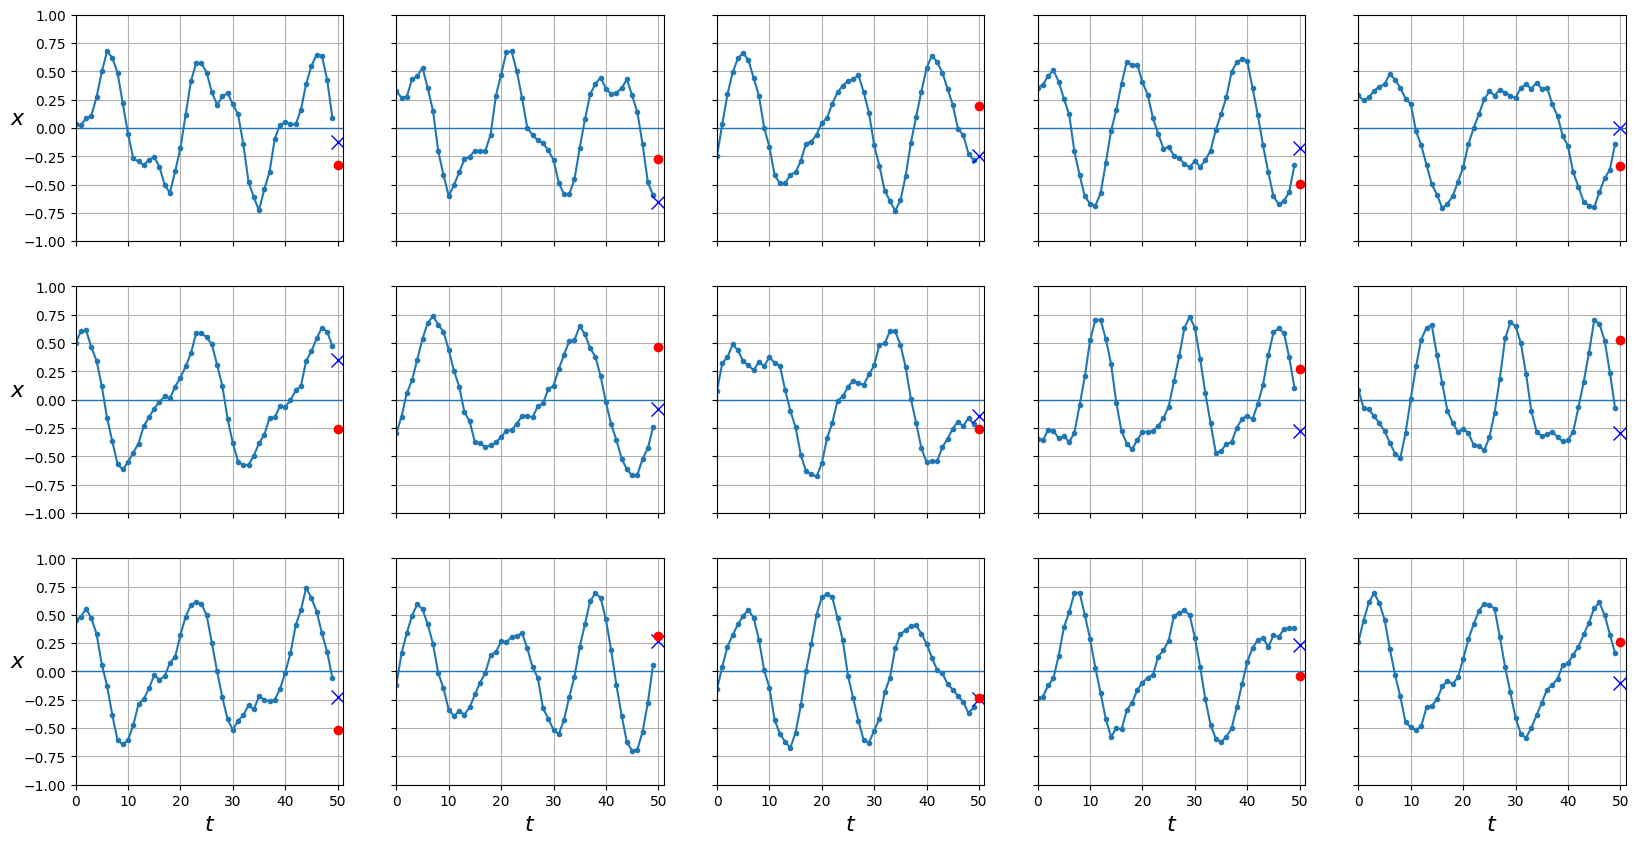

0.28172407

In [59]:
y_pred = predict(rnn_sin_dev, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))